In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
%matplotlib inline
def sigmoid(x):
    return 1/(1+np.exp(-x))
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)

This is the same as last time, so I'll start it up the same way, but this time with one-hot encoding.

In [146]:
data1 = loadmat('../Data/ex4data1.mat')
y = np.c_[data1['y']]
X = data1['X']
y = ohe.fit_transform(y)

In [149]:
weights = loadmat('../Data/ex4weights.mat')
theta1 = weights['Theta1'].T
theta2 = weights['Theta2'].T
thetas = [theta1, theta2]

Now it looks like they want me to build up the cost function, but to do that I also need to bring in the feed forward from the previous exercise.

In [80]:
a2 = sigmoid(X@theta1)
a2 = np.c_[np.ones((a2.shape[0],1)),a2]
a3 = sigmoid(a2@theta2)

In [349]:
def costFunctionNN(X,y,thetas,lamda):
    #expect X to NOT be bias-offset, y to be one-hot encoded, and a list of thetas for each adjacent layer pair
    m = X.shape[0]
    num_layers = len(thetas)+1
    a = []
    a.append(np.c_[np.ones((X.shape[0],1)),X])
    for i in range(1,num_layers):
        a.append(sigmoid(a[i-1]@thetas[i-1]))
        if i<num_layers-1:
            a[i] = np.c_[np.ones((a[i].shape[0],1)),a[i]]
    J = -np.sum(y*np.log(a[num_layers-1])+(1-y)*np.log(1-a[num_layers-1]))/m +\
        lamda*sum([np.sum(theta[1:,:]**2) for theta in thetas])/(2*m)
    return J

In [151]:
costFunctionNN(X,y,thetas,lamda=0)

0.2876291651613189

In [152]:
costFunctionNN(X,y,thetas,lamda=1)

0.384487796242894

The values check out in comparrison with the instructions.

# Now for backpropogation!

In [123]:
theta1.shape

(401, 25)

In [124]:
theta2.shape

(26, 10)

In [381]:
def neuralNetwork(X,y,layers, alpha=.01, lamda=0, iterations=100, gradient_checking=False):
    #expect X to NOT be bias-offset, y to be one-hot encoded, and a list of counts for the number of nodes in each layer
    #i.e. layers[0]=X.shape[1]
    m = X.shape[0]
    L = len(layers)
    #Initialize random thetas
    thetas, regularization_matrix = ([],[])
    for l in range(L-1):
        epsilon = np.sqrt(6/(layers[l]+layers[l+1]))
        thetas.append(epsilon*(2*np.random.rand(layers[l]+1,layers[l+1])-1))
        regularization_matrix.append(np.ones_like(thetas[l]))
        regularization_matrix[l][:,0] = 0
    
    
    J_list = []
    for _ in range(iterations):

        #Initialize Deltas
        Delta = [np.zeros_like(thetas[l]) for l in range(L-1)]

        for i in range(m):
            #Forward propogation
            a = [] # a's will be row vectors
            a.append(np.c_[1,X[i,:].reshape(1,-1)])
            for l in range(1,L):
                a.append(sigmoid(a[l-1]@thetas[l-1]))
                if l<L-1:
                    a[l] = np.c_[1,a[l]]
                else:
                    a[l] = a[l].reshape(1,-1)

            #compute deltas
            delta = [[] for _ in range(L)] #deltas will be row vectors
            delta[L-1] = a[L-1]-y[i,:].reshape(1,-1)
            for l in range(L-2,0,-1):
                delta[l] = (thetas[l]@delta[l+1].T).T*a[l]*(1-a[l])
                delta[l] = delta[l][0,1:].reshape(1,-1)

            #compute Deltas
            for l in range(L-1):
                Delta[l] = Delta[l] + a[l].T@delta[l+1]

        for l in range(L-1):
            thetas[l] -= (alpha/m)*(Delta[l]+lamda*thetas[l]*regularization_matrix[l])
        J_list.append(costFunctionNN(X=X,y=y,lamda=lamda,thetas=thetas))
        
    if gradient_checking:
        dJbdt = [np.zeros_like(Delta[l]) for l in range(L-1)]
        epsilon = .00001
        for l in range(L-1):
            for i1 in range(thetas[l].shape[0]):
                for i2 in range(thetas[l].shape[1]):
                    tmpTheta = np.copy(thetas)
                    tmpTheta[l][i1,i2] += epsilon
                    plus = costFunctionNN(X=X,y=y,lamda=lamda,thetas=tmpTheta)
                    tmpTheta = np.copy(thetas)
                    tmpTheta[l][i1,i2] -= epsilon
                    minus = costFunctionNN(X=X,y=y,lamda=lamda,thetas=tmpTheta)
                    dJbdt[l][i1,i2] = ((plus-minus)/(2*epsilon))
        return dJbdt, Delta
    else:
        return thetas, J_list

In [363]:
layers = [10,2,4]
m = 40
X = np.random.rand(m,10)
y = np.random.randint(1,5,size=(m,1))
y = ohe.fit_transform(y)
dJbdt, Delta = neuralNetwork(X,y,layers, alpha=.01, lamda=0, gradient_checking = True)
[Delta[l]/dJbdt[l]/(2*m) for l in range(len(Delta))]

[array([[1.00615715, 1.01249299],
        [1.00676171, 1.01442786],
        [1.00632002, 1.0144728 ],
        [1.00627362, 1.01580554],
        [1.0058194 , 1.01439507],
        [1.00591769, 1.00828501],
        [1.00639606, 1.00918772],
        [1.00581327, 1.00947961],
        [1.00652594, 1.01327736],
        [1.00645682, 1.01409469],
        [1.00631436, 1.01388343]]),
 array([[1.00350826, 1.00344287, 1.00238504, 1.00331727],
        [1.003326  , 1.00353528, 1.00237894, 1.00333637],
        [1.00386028, 1.0034509 , 1.00230715, 1.00326137]])]

There's a factor of 2 somewhere that I wasn't prepared for and it held me up for a long time. Maybe it's not in the notes, maybe it's something I did, but it looks like my gradient checks out, so I'm just going to roll with it.

In [382]:
data1 = loadmat('../Data/ex4data1.mat')
y = np.c_[data1['y']]
X = data1['X']
y = ohe.fit_transform(y)
layers = [400, 25, 10]

In [402]:
thetas, J_list = neuralNetwork(X=X, y=y, alpha=1, lamda=1, layers=layers, iterations=5000)

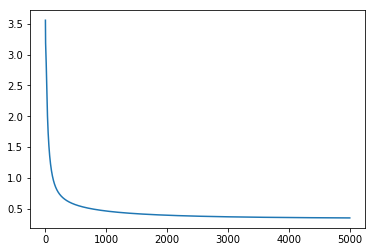

In [403]:
plt.plot(J_list)
plt.show()

In [404]:
a2 = sigmoid(np.c_[np.ones((X.shape[0],1)),X]@thetas[0])
a2 = np.c_[np.ones((a2.shape[0],1)),a2]
a3 = sigmoid(a2@thetas[1])
yGuess = a3.argmax(axis=1)
yActual = y.argmax(axis=1)
print(f'The success rate is {100*sum(yGuess==yActual)/yActual.size}%')

The success rate is 98.88%


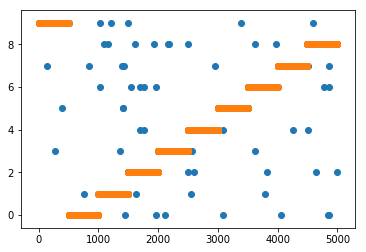

In [405]:
plt.scatter(np.arange(len(yGuess)),yGuess)
plt.scatter(np.arange(len(yGuess)),yActual)
plt.show()